<a href="https://colab.research.google.com/github/RaghavendraGaleppa/Random-Experiments/blob/master/Anchor_Box_Generation_in_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- The Faster RCNN paper introduces anchor boxes as a means of region proposals. Here each pixel in the feature map (50x50) contains around 9 different anchor boxes.

### Anchor Box generation for a single region (a single pixel in the feature map that is fed to the RPN)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

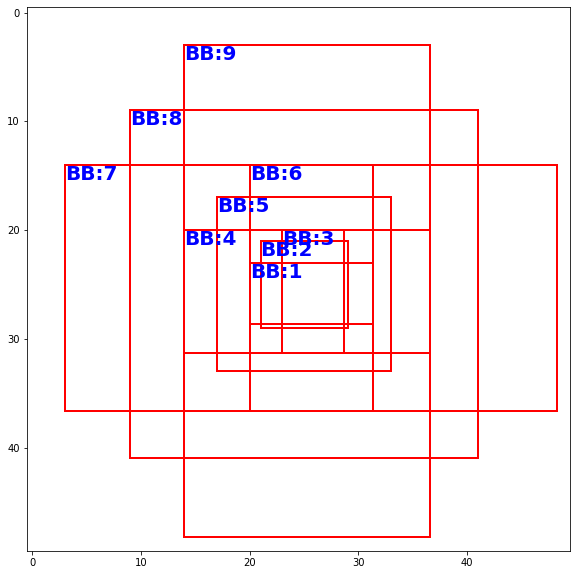

In [46]:
scales = [8, 16, 32] 
aspect_ratios = [0.5, 1, 2]

bounding_boxes = np.zeros((len(scales) * len(aspect_ratios) , 4))

input_size = [50,50] # Feature map size
center_x = input_size[0]//2
center_y = input_size[1]//2
fig, ax = plt.subplots(1,figsize=(10,10))

for i in range(len(scales)):
    for j in range(len(aspect_ratios)):
        h = scales[i] * np.sqrt(aspect_ratios[j])
        w = scales[i] * np.sqrt(1/aspect_ratios[j])
        index = i * len(scales) + j
        bounding_boxes[index,0] = center_x - w//2
        bounding_boxes[index,1] = center_y - h//2
        bounding_boxes[index,2] = w
        bounding_boxes[index,3] = h
        ax.add_patch(Rectangle((bounding_boxes[index,0], bounding_boxes[index,1]), # the top-left x and y
                                 bounding_boxes[index,2], bounding_boxes[index,3], # width and height
                                 lw=2, # line width
                                 color='red',
                                 fill=False)) 

        ax.annotate(f"BB:{index+1}", # The text to display on the bounding box (BB:1 or BB:2)
                    bounding_boxes[index,0:2],  # The top-left coordinates of the Bounding box
                    color='b', fontsize=20, 
                    weight="bold", va="top") # va='top' means that the coordinates given are top left


ax.imshow(np.ones(input_size+[3]))
plt.show()


### Anchor box centers for all the regions

- Assuming that the input image was originally of size 800x800 and had been sub sampled by 16 times. 800//16 will be 50. The new image size is 50x50. 

- Each pixel in the 50x50 image corresponds to 16x16 window in the original image

In [49]:
scales = [8,16,32]
aspect_ratios = [0.5,1,2]

sub_sample = 16
original_i_s = 800 # Original image size
new_i_s = 800//sub_sample # New image size

center_x = np.arange(8, original_i_s, 16)
center_y = np.arange(8, original_i_s, 16)

'\n    - Each red point on the plot represents the center of a region.\n    - Each center point will have 9 anchor boxes.\n    - So we have 50*50*9 anchor boxes or region proposals\n'

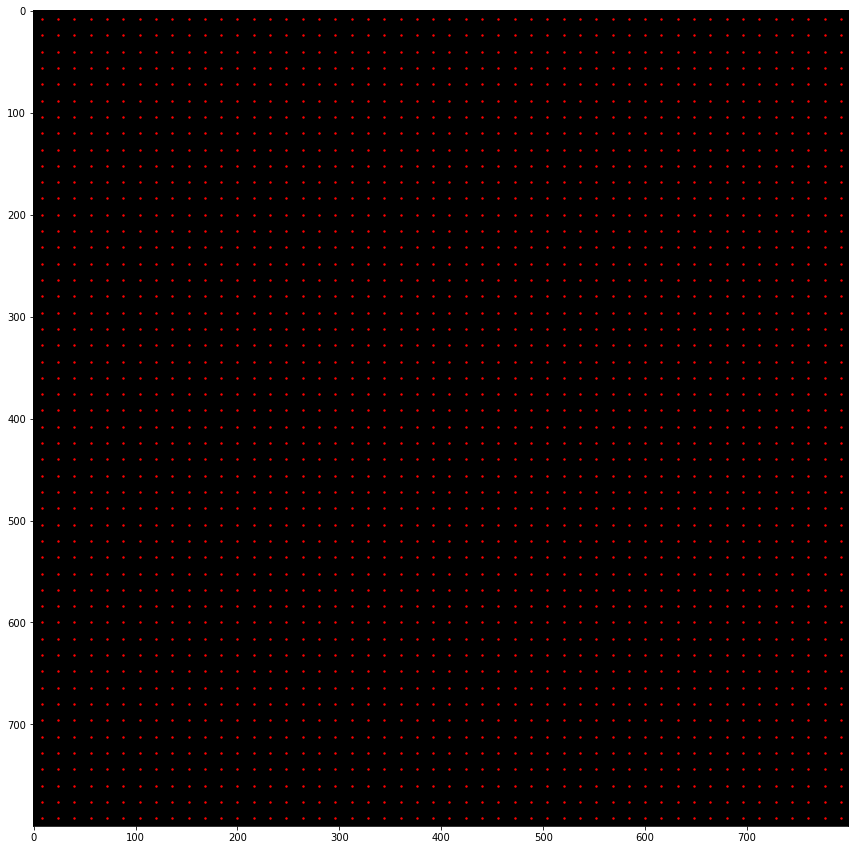

In [50]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.imshow(np.zeros((original_i_s, original_i_s,3)))
for i in center_x:
    for j in center_y:
        ax.scatter(i,j,s=2,c='r') # The parameter s=2 is the size of the point


"""
    - Each red point on the plot represents the center of a region.
    - Each center point will have 9 anchor boxes.
    - So we have 50*50*9 anchor boxes or region proposals
"""

### Generating Anchor Boxes for all of the centers

In [51]:
def generate_anchor_boxes(c_x:int, c_y:int, 
                          scales=[8,16,32],
                          aspect_ratios=[0.5,1,2],
                          sub_sample_size=1):
    """
        This function will generate anchor boxes for that particular scale and aspect ratios
        Args:
            c_x, c_y: Center x and y coordinates, should be int
            scales: List of scales for the anchor boxes. Should be a list of ints.
            aspect_ratios: List of aspect ratios for the anchor boxes. Should be list of floats.
            
            sub_sample_size(int): 
                - This parameter defines the size of the bounding in the original image. 
                - If an image has not been sub sampled, then this remains 1. 
                - In case of Faster RCNN, the original image is not used, its feature is used to generate
                anchor boxes. So the anchor box coordinates will remain for the feature map and not the original 
                image. Multiplying anchor box height and width with sub_sample_size will yeild those anchor boxes
                for the original image.

        Returns:
            anchor_box(np.ndarray): List of all bounding boxes that can be produced using the 
            scales and aspect_ratios provided.
    """

    anchor_boxes = np.zeros((len(scales)*len(aspect_ratios),4), dtype=np.float32)

    for i in range(len(scales)):
        for j in range(len(aspect_ratios)):
            index = i*len(scales) + j
            w = sub_sample_size * scales[i] * np.sqrt(aspect_ratios[j])
            h = sub_sample_size * scales[i] * np.sqrt(1./aspect_ratios[j])

            anchor_boxes[index,0] = c_x - w//2 # x top-left
            anchor_boxes[index,1] = c_x - h//2 # y top-left
            anchor_boxes[index,2] = w
            anchor_boxes[index,3] = h

    return anchor_boxes


In [63]:
def plot_anchor_boxes(anchor_boxes,
                      img_size=(800,800,3),
                      figsize=(10,10),
                      ignore_negative=False):
    """
        This function plots the anchor boxes for a given region
        args:
            anchor_boxes(np.ndarray): List of anchor boxes, typically of shape, (n,4)
            img_size: Size of the image on which these anchor boxes are generated
            figsize: The size of the plot window
            ignore_negative: Ignore anchor boxes with negative coordinates
    """

    fig, ax = plt.subplots(1,figsize=figsize)

    for i in range(anchor_boxes.shape[0]):

        # ignore the bounding boxes with negative coordinates
        if np.any(anchor_boxes[i] < 0) and ignore_negative: 
            continue

        patch = Rectangle(anchor_boxes[i,0:2],
                          *anchor_boxes[i,2:4],
                          lw=2,
                          color='red',
                          fill=False)

        ax.add_patch(patch)
        ax.annotate(f'BB:{i+1}',
                    anchor_boxes[i,0:2],
                    c='white',
                    fontsize=10,
                    va='top')

    ax.imshow(np.zeros(img_size))

        

In [64]:
anchor_boxes = np.zeros((new_i_s * new_i_s, len(scales)*len(aspect_ratios), 4),dtype=np.float32)

for i in range(anchor_boxes.shape[0]):
    c_x = center_x[i//new_i_s] 
    c_y = center_y[i%new_i_s]

    anchor_boxes[i] = generate_anchor_boxes(c_x, c_y, 
                                            sub_sample_size=16,)

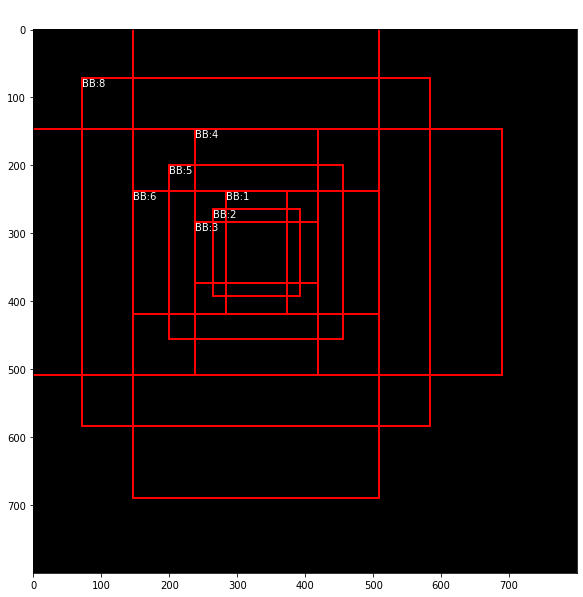

In [68]:
plot_anchor_boxes(anchor_boxes[1000])